# Unevenly space time series – tick data
In this notebook we will explore some very basic techniques for handling intraday stock trade data, called **tick data**.  Stock trades are unevenly spaced in time, and such a time series is called an **unevenly spaced time series** or an **irregular time series**.

In [1]:
import pandas as pd
import matplotlib as mpl
%matplotlib inline

We set the default `matplotlib` figure size to be wider.

In [6]:
mpl.rcParams['figure.figsize'] = (15,5)

We read in the CSV file of just a small number of trades, and set the first column of dates/times to be the index column.  We also want to convert the strings of dates/times to be pandas timestamps.

In [5]:
small_sample = pd.read_csv("TeslaTickData.csv", index_col=0, parse_dates=True)
small_sample.head()

,NLS Price,NLS Share Volume
NLS Time (ET),,
2021-05-03 12:28:40,738.24,100
2021-05-03 12:28:40,738.26,100
2021-05-03 12:28:43,738.15,100
2021-05-03 12:28:43,738.15,600
2021-05-03 12:28:43,738.26,100


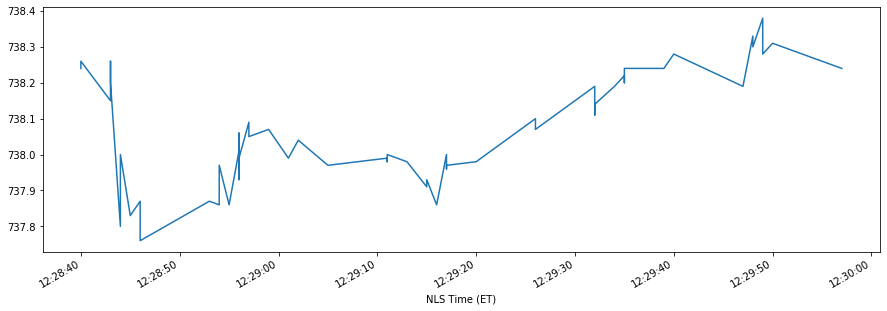

In [7]:
small_sample["NLS Price"].plot()

This plot would look better if we also plotted small dots at the trade price.  We can also set the dot colors to be red.

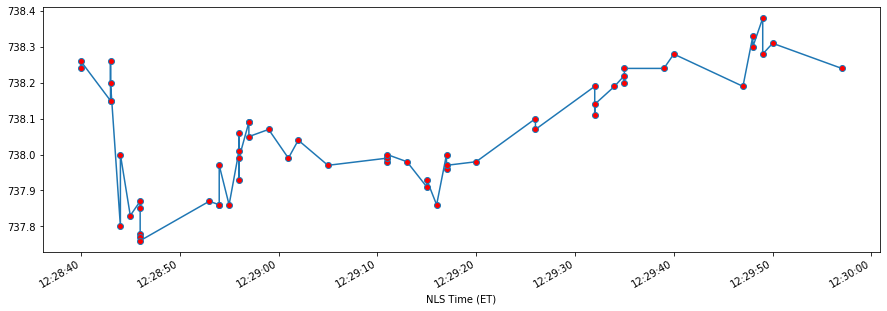

In [24]:
small_sample["NLS Price"].plot(marker="o", markerfacecolor="red")

Next let's read in a bigger file which consists of all Tesla trades across all exchange for a single day (July 1, 2020).

In [25]:
df = pd.read_csv("TSLA_2020-07-01.txt")
df.head()

,2020-07-01 04:00:00:039,1082.91,400,ARCX
0,2020-07-01 04:00:00:050,1077.00,3,ARCX
1,2020-07-01 04:00:00:050,1076.00,7,ARCX
2,2020-07-01 04:00:00:143,1075.30,1,ARCX
3,2020-07-01 04:00:00:143,1075.23,4,ARCX
4,2020-07-01 04:00:00:143,1075.04,25,ARCX


We'll need to specify our own column names, and set the first column to be the index.

In [26]:
df = pd.read_csv("TSLA_2020-07-01.txt", names=["Time", "Price", "Volume", "Exchange"],
                 index_col=0)
df.head()

,Price,Volume,Exchange
Time,,,
2020-07-01 04:00:00:039,1082.91,400,ARCX
2020-07-01 04:00:00:050,1077.00,3,ARCX
2020-07-01 04:00:00:050,1076.00,7,ARCX
2020-07-01 04:00:00:143,1075.30,1,ARCX
2020-07-01 04:00:00:143,1075.23,4,ARCX


However, our index column of dates and times are still in string format.

In [28]:
type(df.index[0])

str

Unforunately, the default pandas date parser is unable to parse this date/time format.

In [30]:
df = pd.read_csv("TSLA_2020-07-01.txt", names=["Time", "Price", "Volume", "Exchange"],
                 index_col=0, parse_dates=True)
type(df.index[0])

str

What went wrong?  By default, pandas expects fractions of seconds to be preceeded by a decimal point, e.g. "2020-07-01 04:00:00.039", rather than preceed by a colon, e.g. "2020-07-01 04:00:00:039".

We can fix this by writing our own function to parse the dates and times.

In [32]:
def parse_colon(x):
    return pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S:%f")
df = pd.read_csv("TSLA_2020-07-01.txt", names=["Time", "Price", "Volume", "Exchange"],
                index_col=0, date_parser=parse_colon)
type(df.index[0])

pandas._libs.tslibs.timestamps.Timestamp

Let's plot the prices.

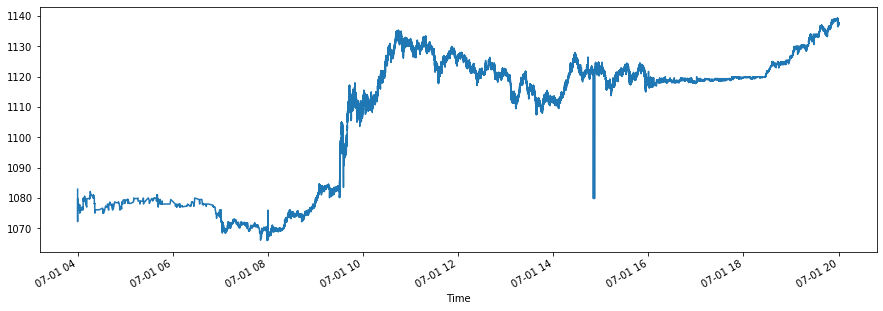

In [33]:
df["Price"].plot()

We can make the above plot look better by formatting the x-axis to display only time of day (in hours and minutes) rather than displaying the date.  Let's also turn on a grid to make it easier to read.  Also, we can do this for each plot, but it is more convenient to set it as a `matplotlib` default for the rest of this notebook. 

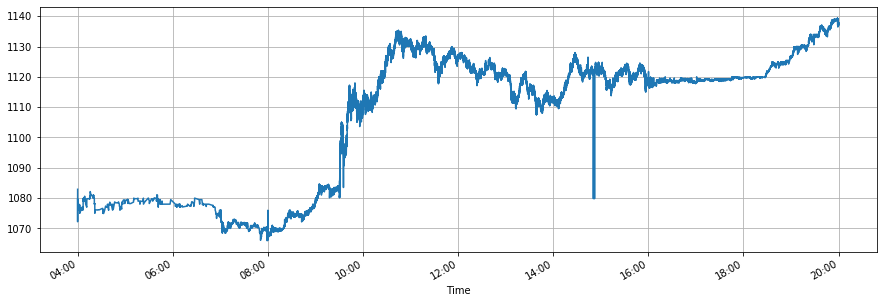

In [34]:
mpl.rcParams['date.autoformatter.hour'] = '%H:%M'
mpl.rcParams['axes.grid'] = True
df["Price"].plot()

We can also select a sub-range of times that we are interested in.  For example, regular stock exchange trading hours go from 9:30 am to 4:00 pm.

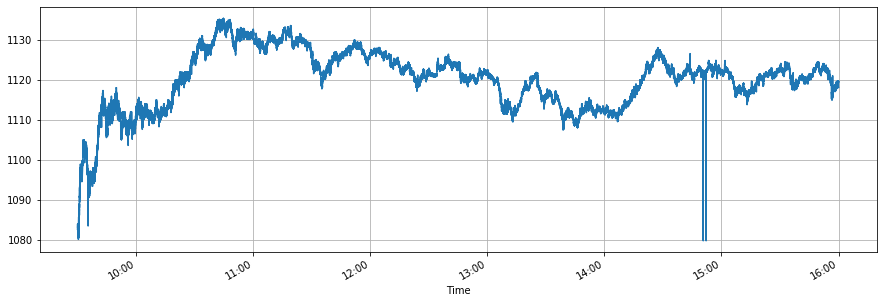

In [35]:
trading_hours = df['2020-07-01 09:30:00':'2020-07-01 16:00:00']
trading_hours["Price"].plot()

Notice that there are two outlier trades that happened shortly before 3 pm.

What if we want to only look at the trades on a particular exchange?  For example, we can filter trades that happened on the Nasdaq exchange (exchange code "XNGS"), which happens to be Tesla's primary exchange.

First we can create a series of booleans (true/false) that tell us if the corresponding trade happened on the Nasdaq or not.

In [39]:
trading_hours["Exchange"]=="XNGS"

Time
2020-07-01 09:30:00.007    False
2020-07-01 09:30:00.007     True
2020-07-01 09:30:00.017     True
2020-07-01 09:30:00.018    False
2020-07-01 09:30:00.028    False
                           ...  
2020-07-01 16:00:00.464    False
2020-07-01 16:00:00.683     True
2020-07-01 16:00:00.683     True
2020-07-01 16:00:00.683     True
2020-07-01 16:00:00.684     True
Name: Exchange, Length: 317420, dtype: bool

Now we filter on just those indices listed as "true".

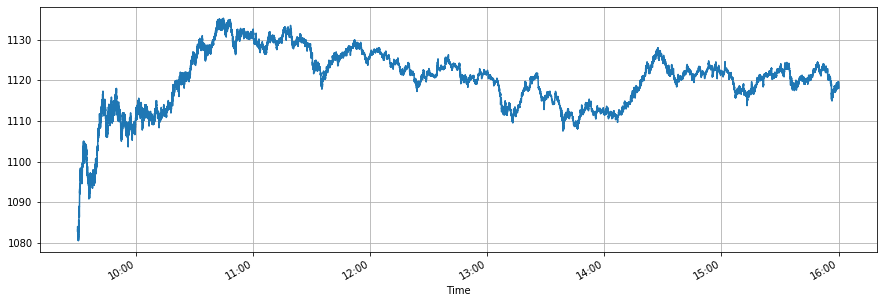

In [40]:
nasdaq = trading_hours[trading_hours["Exchange"]=="XNGS"]
nasdaq["Price"].plot()

We no longer see the two outlier trades, so they must not have happened on the Nasdaq exchange.

We can also plot the volume, i.e. the number of shares traded for each trade.

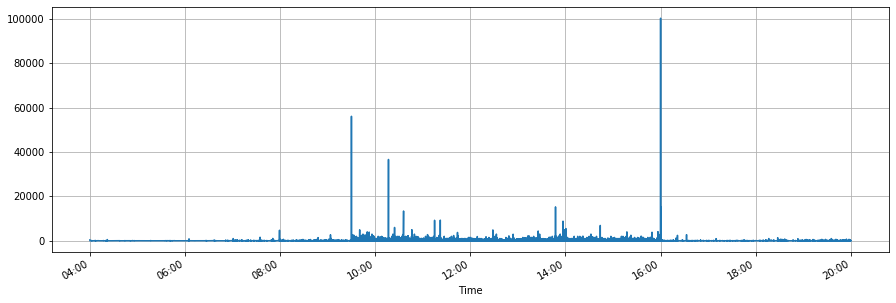

In [41]:
df["Volume"].plot()

Observe that there are quite large volumes that traded at 9:30 am and 4:00 pm.  These reflect the volumes traded on the **opening** and **closing auctions** respectively.

We can combine the plots of the prices and volumes into a single plot with two different vertical axes.

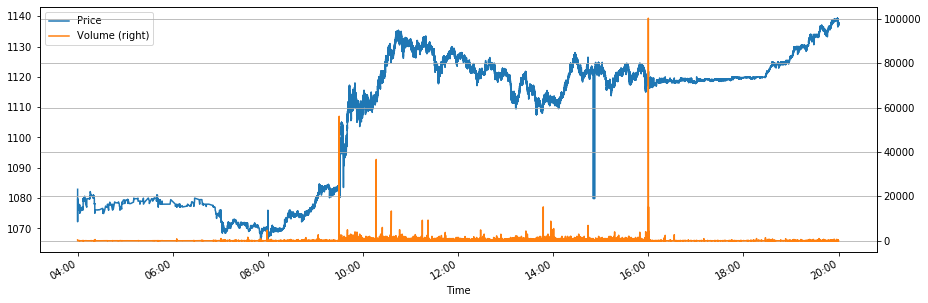

In [42]:
df.plot(secondary_y = ["Volume"])

Let's check the summary statistics of each column.

In [10]:
df.describe()

,Price,Volume
count,331241.000000,331241.000000
mean,1117.304823,40.706108
std,11.447231,314.153643
min,1065.930000,1.000000
25%,1111.940000,2.000000
50%,1119.600000,10.000000
75%,1125.000000,49.000000
max,1139.340000,100235.000000


We see that there are more than 300,000 Tesla trades reported, but most trades are rather small.  In fact, more than 75% of trades are less than 50 shares, and at least 25% of trades are only 1 or 2 shares.  But more than 100,000 shares (approx \\$100M) traded on the closing auction.

We can also display the summary statistics for the trades on each exchange by using the `groupby()` method.

In [44]:
df.groupby("Exchange").describe()

Price                                                        \
             count         mean        std      min        25%       50%   
Exchange                                                                   
ARCX       31385.0  1116.089929  13.463145  1065.93  1111.2700  1119.110   
BATS       18178.0  1117.316411  10.786178  1068.00  1112.0000  1119.500   
BATY        1851.0  1117.699641  10.928949  1068.30  1112.2050  1119.710   
EDGA        3684.0  1117.718522  11.263319  1071.49  1111.6500  1119.665   
EDGX       23332.0  1115.446737  14.605170  1066.00  1111.0000  1119.000   
FINR      127343.0  1118.247624  10.242406  1066.09  1112.3809  1120.000   
IEXG        2753.0  1116.389993   9.695896  1082.26  1111.7400  1118.195   
PHLX        3298.0  1116.533481  10.552270  1081.00  1110.5800  1117.090   
XASE         320.0  1118.553281   8.587504  1090.00  1112.1950  1119.475   
XCHI         711.0  1118.430467  10.715088  1068.25  1113.4400  1120.720   
XCIS         588.0  1118.367679   9.633247  1074.63  1112.5100  1119.950   
XNAS        1549.0  1117.670013  10.447848  1068.73  1113.1400  1119.310   
XNGS      113112.0  1116.980187  11.535774  1066.05  1111.5700  1119.340   
XNYS        3137.0  1116.778770   9.963249  1080.84  1111.6400  1118.550   

                                Volume                                     \
                75%      max     count        mean         std  min   25%   
Exchange                                                                    
ARCX      1124.8200  1139.29   31385.0   33.613669   79.742430  1.0   3.0   
BATS      1124.2200  1139.00   18178.0   33.562713   46.673665  1.0   3.0   
BATY      1125.5000  1135.01    1851.0   53.191788   44.707415  1.0   6.0   
EDGA      1126.1025  1134.98    3684.0   35.433496   42.522680  1.0   2.0   
EDGX      1124.7700  1139.34   23332.0   27.842191   63.235029  1.0   2.0   
FINR      1125.4956  1139.30  127343.0   52.755519  203.957359  1.0   2.0   
IEXG      1122.0800  1135.25    2753.0   48.478750   54.830961  1.0   1.0   
PHLX      1124.5475  1134.93    3298.0   17.322923   33.405556  1.0   2.0   
XASE      1124.1075  1135.00     320.0   21.625000   35.924642  1.0   1.0   
XCHI      1124.1600  1134.99     711.0  111.891702  714.206181  1.0  10.5   
XCIS      1123.8425  1134.97     588.0   29.554422   31.104957  1.0   2.0   
XNAS      1123.6900  1134.60    1549.0   23.570691   33.584495  1.0   2.0   
XNGS      1124.7100  1139.30  113112.0   33.139243  485.208635  1.0   3.0   
XNYS      1123.2800  1135.00    3137.0   45.395601   45.740081  1.0   2.0   

                                 
           50%    75%       max  
Exchange                         
ARCX      11.0   49.0    9154.0  
BATS      11.0   50.0     800.0  
BATY      46.0  100.0     300.0  
EDGA      10.0   94.0     300.0  
EDGX       7.0   26.0    2700.0  
FINR      10.0   50.0   36619.0  
IEXG      23.0  100.0     700.0  
PHLX       4.0   16.0     600.0  
XASE       2.0   17.5     100.0  
XCHI      73.0  100.0   15250.0  
XCIS      25.0   40.0     100.0  
XNAS      10.0   35.0     300.0  
XNGS      11.0   44.0  100235.0  
XNYS      30.0  100.0     343.0

Let's just look at the summary statistics for volume per exchange, and clean up the output by rounding everything to the nearest integer.

In [45]:
df.groupby("Exchange")["Volume"].describe().round(0).astype(int)

,count,mean,std,min,25%,50%,75%,max
Exchange,,,,,,,,
ARCX,31385,34,80,1,3,11,49,9154
BATS,18178,34,47,1,3,11,50,800
BATY,1851,53,45,1,6,46,100,300
EDGA,3684,35,43,1,2,10,94,300
EDGX,23332,28,63,1,2,7,26,2700
FINR,127343,53,204,1,2,10,50,36619
IEXG,2753,48,55,1,1,23,100,700
PHLX,3298,17,33,1,2,4,16,600
XASE,320,22,36,1,1,2,18,100


We see that the "**FINR**" exchange had even more trades than Nasdaq ("XNGS").  What is this "FINR" exchange?  Actually, "FINR" stands for **FINRA** (the Financial Industry Regulatory Authority).  FINRA is *not* an exchange; it is a type of regulator called a **self-regulatory organization (SRO)**, and it regulates all U.S. securities firms.  When trades happen off exchange, e.g. in so-called **dark-pools**, they are reported to a FINRA **trade reporting facility (TRF)**.  They are supposed to be reported within 10 seconds of execution, although sometimes trades are reported late.

Let's use our filtering trick to look at all trades of 10,000 shares or more.

In [46]:
df[df["Volume"]>=10000]

,Price,Volume,Exchange
Time,,,
2020-07-01 09:30:00.442,1083.5000,56065,XNGS
2020-07-01 09:30:00.442,1083.5000,56065,XNGS
2020-07-01 10:16:44.099,1114.2500,36619,FINR
2020-07-01 10:35:45.205,1126.9500,13400,FINR
2020-07-01 13:47:27.203,1111.4918,15250,XCHI
2020-07-01 16:00:00.301,1119.6300,100235,XNGS
2020-07-01 16:00:00.301,1119.6300,100235,XNGS
2020-07-01 16:00:02.570,1119.6300,29000,FINR
2020-07-01 16:00:14.295,1121.7500,15250,FINR


Note that the opening print of 56,065 shares at \\$1083.50 is duplicated (the actual trade only happened once).  Similarly, the closing print of 100,235 shares at \\$1119.63 only happened once.  These trades establish the day's official opening and closing prices respectively.

Let's also look for outliers by filtering on all trades that were more than \\$10 different from the previous trade's price.

In [47]:
# 1079.81 was previous day's close and 1083.50 was today's opening print
df[df["Price"].diff().abs() > 10]

,Price,Volume,Exchange
Time,,,
2020-07-01 09:35:21.119,1083.5000,121,FINR
2020-07-01 09:35:21.130,1095.1629,20,FINR
2020-07-01 09:35:23.044,1083.5000,7,FINR
2020-07-01 09:35:23.075,1095.4150,100,FINR
2020-07-01 14:50:39.879,1079.8100,1,FINR
2020-07-01 14:50:40.417,1121.9900,4,XNGS
2020-07-01 14:52:08.946,1079.8100,1,FINR
2020-07-01 14:52:08.946,1122.2100,3,XNGS


It is a good practice to look for outliers.  But before filtering outliers out, it is often worth your time to understand where the outliers came from.  By asking and answering questions about outliers, you come to a better understanding of your data generating process.

So let's examine the above outliers more closely.  In fact, there are only *four* outlying trades, not eight.  For each of four pairs of trades, the first trade is the actual outlier, and the next trade is the reversion back to "correct" price.

For example, the 121 shares at \\$1083.50 is an outlier, but the 20 shares at \\$1095.1629 is *not* an outlier.

The first two outlying trades, 121 shares and 7 shares, represent off-exchange crosses made at the day's opening price of \\$1083.50.

The last two outliers are both for 1 share each, and are done at the *previous* day's closing price of \\$1079.81.  These two trades were the extreme outliers we saw in the earlier plots.

Also note that all four of these outliers were traded on a FINRA TRF.

Let's also plot just the Nasdaq prices but also superimpose all trades (from any exchange) in the amount of 5000 shares or more.

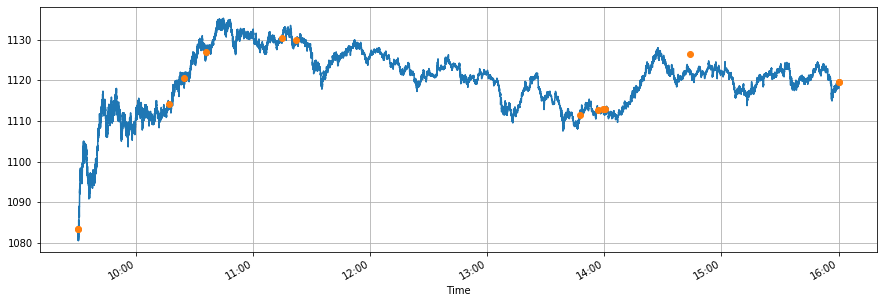

In [49]:
nasdaq["Price"].plot()
trading_hours[trading_hours["Volume"]>=5000]["Price"].plot(style='o')

Sometimes when enountering a time series of a given frequency, we seek to convert it to a new time series of a different frequency.  This is called **resampling**, of which there are two different flavors:

**Upsampling** - Sampling the time series at a higher frequency; need to fill in or interpolate values.

**Downsampling** - Sampling the time series at a lower frequency; need to aggregate values.

However, when resampling an **irregular time series** like tick data, we are often simultaneously dealing with both the issues of interpolation and aggregation, as we will see below.

First, let's downsample our price data to convert it to a regularly spaced time series of interval 1 second between values.  But when downsampling, we need to make a choice about how to aggregate values over the 1 second interval.  For example, we can take the mean.

In [52]:
nasdaq["Price"].resample("1S").mean().head(3)

Time
2020-07-01 09:30:00    1083.488514
2020-07-01 09:30:01    1083.487843
2020-07-01 09:30:02    1083.625172
Freq: S, Name: Price, dtype: float64

For volume traded, it may make more sense to aggregate values over an interval by taking the sum, i.e. the total number of shares traded during the interval.  Let's downsample our volume data and convert it to an hourly series by taking the sum over each hour.

In [53]:
nasdaq["Volume"].resample("1H").sum().head(3)

Time
2020-07-01 09:00:00    912368
2020-07-01 10:00:00    764412
2020-07-01 11:00:00    460966
Freq: H, Name: Volume, dtype: int64

Another common aggregation technique common in finance is the "open/high/low/close" (**OHLC**), where  "open" is the first observation in the interval, "high" is the maximum observation, "low" is the minimum, and "close" is the last observation in the interval.  Let's use the `ohlc()` method to downsample our data to 1 minute intervals.

In [17]:
nasdaq["Price"].resample("1min").ohlc().head(3)

,open,high,low,close
Time,,,,
2020-07-01 09:30:00,1083.25,1090.93,1080.50,1090.665
2020-07-01 09:31:00,1090.90,1098.38,1090.90,1097.940
2020-07-01 09:32:00,1097.94,1104.96,1094.54,1104.660


If we want to apply two different aggregation method, e.g. "mean" for price data and "sum" for volume data, we can do that using the `agg()` method.

In [56]:
nasdaq.resample("1min").agg({"Price": "mean", "Volume": "sum"}).head(3)

,Price,Volume
Time,,
2020-07-01 09:30:00,1085.567198,164206
2020-07-01 09:31:00,1095.691698,42999
2020-07-01 09:32:00,1100.008903,52216


If we change our resampling interval to only 0.01 seconds, then enounter the issue of possibly needing to interpolate or otherwise fill in missing values.

In [57]:
nasdaq.resample("0.01S").agg({"Price": "mean", "Volume": "sum"}).head(15)

,Price,Volume
Time,,
2020-07-01 09:30:00.000,1083.250000,91
2020-07-01 09:30:00.010,1083.210000,54
2020-07-01 09:30:00.020,NaN,0
2020-07-01 09:30:00.030,NaN,0
2020-07-01 09:30:00.040,NaN,0
2020-07-01 09:30:00.050,NaN,0
2020-07-01 09:30:00.060,NaN,0
2020-07-01 09:30:00.070,NaN,0
2020-07-01 09:30:00.080,1082.986667,37


We see that our price data has missing values for certain periods.  Sometimes it is okay to just leave the missing values as they are, but at other times we may want to fill in those missing values.  In financial time series of prices, we often use the most recent previously traded price to fill in the missing values.  This is called **forward filling**.

In [76]:
nasdaq.resample("0.01S").agg({"Price": "mean", "Volume": "sum"}).ffill().head(15)

,Price,Volume
Time,,
2020-07-01 09:30:00.000,1083.250000,91
2020-07-01 09:30:00.010,1083.210000,54
2020-07-01 09:30:00.020,1083.210000,0
2020-07-01 09:30:00.030,1083.210000,0
2020-07-01 09:30:00.040,1083.210000,0
2020-07-01 09:30:00.050,1083.210000,0
2020-07-01 09:30:00.060,1083.210000,0
2020-07-01 09:30:00.070,1083.210000,0
2020-07-01 09:30:00.080,1082.986667,37


Let's aggregate our data into 1 minute intervals and analyze it using traditional methods.

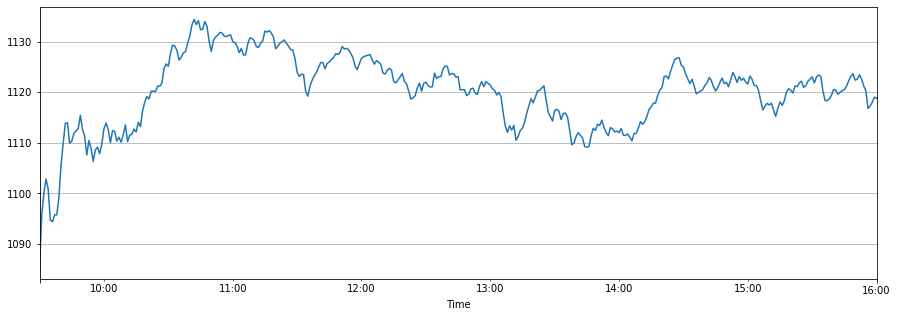

In [73]:
nasdaq_seconds = nasdaq.resample("1min").agg({"Price": "mean", "Volume": "sum"}).ffill()
nasdaq_seconds["Price"].plot()

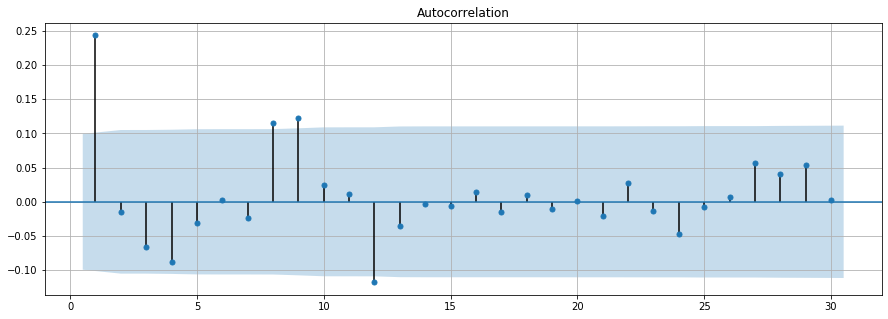

In [74]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(nasdaq_seconds["Price"].diff().dropna(), lags=range(1,31));

***Warning!*** The highly positive lag-1 autocorrelation is an artifact of our averaging process.  It isn't real!  Why does this happen?  Let's look at a simpler example:

Suppose you have a random walk:
$$X_t = X_{t-1} + \epsilon_t$$
Consider six observations, $X_1, X_2, X_3, X_4, X_5,$ and $X_6$, and suppose you average over three periods each of length two:
$$\frac{X_1+X_2}{2}, \frac{X_3+X_4}{2}, \frac{X_5+X_6}{2}.$$

Now you take differences of the averaged values:
$$\frac{X_3+X_4}{2} - \frac{X_1+X_2}{2} = \frac12 \epsilon_1 + \epsilon_2 + \frac12 \epsilon_3,$$
$$\frac{X_5+X_6}{2} - \frac{X_3+X_4}{2} = \frac12 \epsilon_3 + \epsilon_4 + \frac12 \epsilon_5.$$

Finally, if we take covariances, we get positive covariance.
$$\operatorname{Cov}\left(\frac{X_3+X_4}{2} - \frac{X_1+X_2}{2}, \frac{X_5+X_6}{2} - \frac{X_3+X_4}{2}\right)$$
$$= \operatorname{Cov\left(\frac12 \epsilon_1 + \epsilon_2 + \frac12 \epsilon_3, \frac12 \epsilon_3 + \epsilon_4 + \frac12 \epsilon_5 \right)} = \frac14 \sigma_\epsilon^2.$$

If we instead replace the *mean* of prices over each minute with the *last* price of each minute, then this positive autocorrelation disappears.

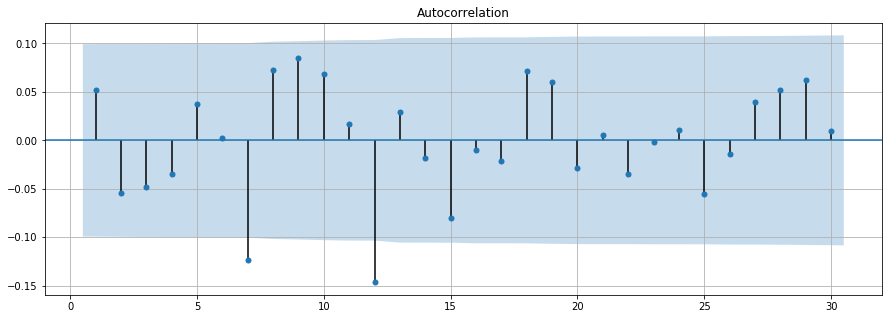

In [78]:
nasdaq_seconds = nasdaq.resample("1min").agg({"Price": "last", "Volume": "sum"}).ffill()
plot_acf(nasdaq_seconds["Price"].diff().dropna(), lags=range(1,31));

We can also calculate the sample autocorrelation function on the original tick data itself.  In essence, our time axis is by "tick" rather than clock time.

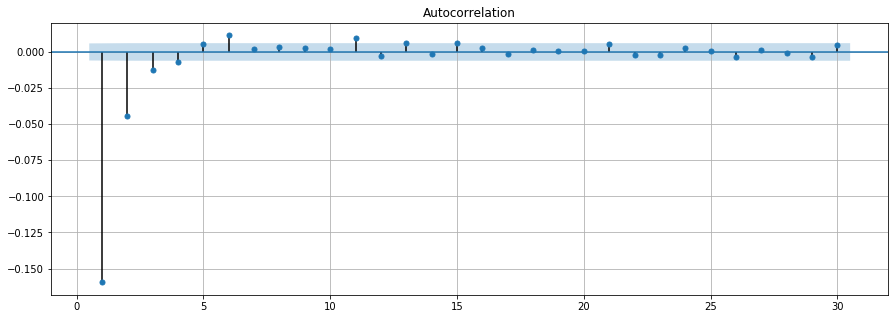

In [79]:
plot_acf(nasdaq["Price"].diff().dropna(), lags=range(1,31));

Now at the level of tick data, we see a substantial *negative* lag-1 autocorrelation.  But this is actually an artifact of what is called **bid-ask bounce**.  The **bid** of a stock is the highest price at which someone is willing to buy, and the **ask** (or **offer**) is the lowest price at which someone is willing to sell.  The last traded price of a stock can "bounce" back and forth between the bid and the ask prices, generating apparent negative autocorrelation, but without the bid and ask prices themselves actually moving.

Finally, when considering lag-1 autocorrelations, it is a good idea to examine a scatter plot and check for egregious outliers that might affect the sample correlation measurement.

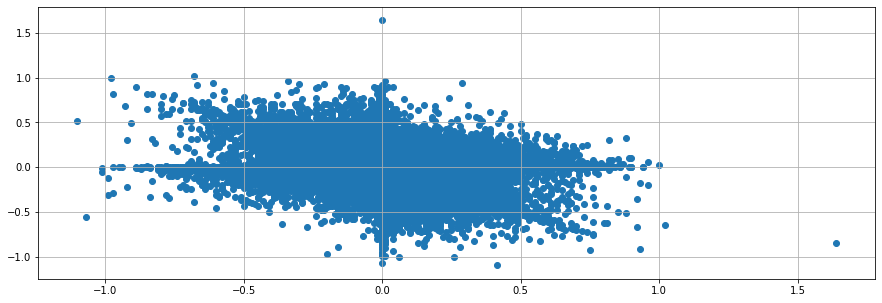

In [81]:
import matplotlib.pyplot as plt
deltaP = nasdaq["Price"].diff()
plt.scatter(deltaP, deltaP.shift(-1))